## Basic Setup
First, we need to set up accounts and download relevant data.
Running this will install required libraries, and prompt for AWS access credentials.

In [ ]:
# Setup AWS CLI
!pip install awscli
!aws configure

In [ ]:
# Download data from S3.
# This will stay on this machine only as long as the session is active, and will be deleted afterwards.
!aws s3 cp --recursive s3://uoftremmiedata/diagnosis_images ./data

In [ ]:
# Install some additional libraries required, before the rest are imported.
!pip install torchmetrics
!pip install pytorch-lightning

In [ ]:
# General imports.
import math

from PIL import Image

import torch
import torchmetrics
import torchvision.datasets
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torch import nn
import pytorch_lightning as pl

import matplotlib.pyplot as plt

# Enable reproducible results.
torch.manual_seed(42)

In [ ]:
# Upload normal_diagnosis.zip to session storage from local storage
# Then run this code to unzip
!unzip "/content/normal_diagnosis.zip" -d "/content/data"

In [ ]:
# For this model, we are classifying between healthy ear drums and those with Otitis Media (OM). We group the various types of OM (AOM, ASOM, CSOM, OME) together to compare against normal ears.
!mkdir /content/om_vs_normal_data
!cp -r /content/data/None\ Of\ Above/. /content/om_vs_normal_data/normal
!cp -r /content/data/AOM/. /content/om_vs_normal_data/om
!cp -r /content/data/ASOM/. /content/om_vs_normal_data/om
!cp -r /content/data/CSOM/. /content/om_vs_normal_data/om
!cp -r /content/data/OME_\(Serous_OM\)/. /content/om_vs_normal_data/om

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `cp -r /content/data/OME_(Serous_OM)/. /content/om_vs_normal_data/om'


Load the image dataset

In [ ]:
#https://www.binarystudy.com/2022/04/how-to-normalize-image-dataset-inpytorch.html#:~:text=To%20normalize%20the%20image%20dataset,above%20calculated%20mean%20and%20std.&text=If%20our%20dataset%20is%20more,0.229%2C%200.224%2C%200.225%5D.
data_path = '/content/om_vs_normal_data'

transform_img = T.Compose([
    T.CenterCrop(1500),
    T.RandomRotation(180),
    T.RandomResizedCrop(224, (0.7, 1)),
    T.RandomHorizontalFlip(0.5),
    T.ToTensor()
    #here do not use transforms.Normalize(mean, std)
])

image_data = torchvision.datasets.ImageFolder(
  root=data_path, transform=transform_img
)

#set batch size to entire dataset to calculate mean and std
image_data_loader = DataLoader(
  image_data,
  batch_size=len(image_data),
  shuffle=False,
  num_workers=0
)

Calcuate mean and standard deviation of images. Since the images are similar in colour, this should be done manually (and not use the standard ImageNet mean and std).

In [ ]:
# python code calculate mean and std https://www.binarystudy.com/2022/04/how-to-normalize-image-dataset-inpytorch.html#:~:text=To%20normalize%20the%20image%20dataset,above%20calculated%20mean%20and%20std.&text=If%20our%20dataset%20is%20more,0.229%2C%200.224%2C%200.225%5D.
from torch.utils.data import DataLoader
image_data_loader = DataLoader(
    image_data,
    # batch size is whole dataset
    batch_size=len(image_data),
    shuffle=False,
    num_workers=0)
def mean_std(loader):
  images, lebels = next(iter(loader))
  # shape of images = [b,c,w,h]
  mean, std = images.mean([0,2,3]), images.std([0,2,3])
  return mean, std
mean, std = mean_std(image_data_loader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([0.6243, 0.6003, 0.5717]) tensor([0.2209, 0.2121, 0.2039])


With mean = [0.6243, 0.6003, 0.5717] and std = [0.2209, 0.2121, 0.2039], we can normalize the images

In [ ]:
# python code to normalize the image

import torchvision
from torchvision import transforms as T
from torch.utils.data import DataLoader

data_path = '/content/om_vs_normal_data'

transform_img_normal = T.Compose([
    T.CenterCrop(1500),
    T.RandomRotation(180),
    T.RandomResizedCrop(224, (0.7, 1)),
    T.RandomHorizontalFlip(0.5),
    T.ToTensor(),
    T.Normalize(mean = [0.6243, 0.6003, 0.5717],
                         std= [0.2209, 0.2121, 0.2039])
])

image_data_normal = torchvision.datasets.ImageFolder(
  root=data_path,
  transform=transform_img_normal
)

image_data_loader_normal = DataLoader(
  image_data,
  batch_size=len(image_data),
  shuffle=False,
  num_workers=0
)

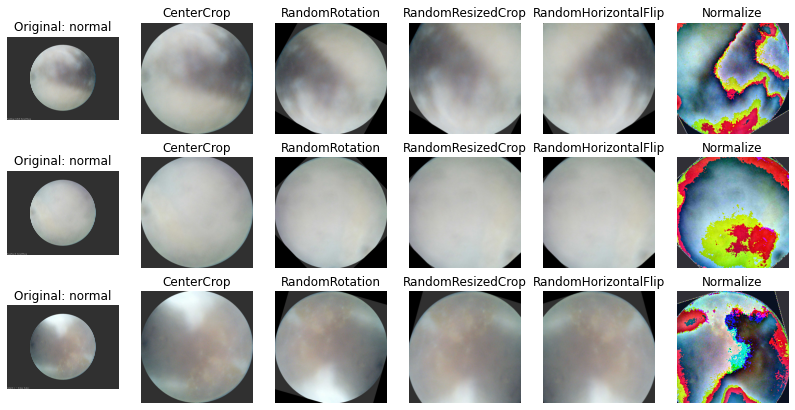

In [ ]:
# function to visually display what each transform does
def show_transforms(dataset, transform_list, num_samples=5):
  fig = plt.figure(figsize=(14, 7))
  cols = len(transform_list) #include original image, ignore to tensor
  rows = num_samples
  position = 1
  for i in range(rows):
    #display original image
    image, label = dataset[i]
    fig.add_subplot(rows, cols, position)
    position = position + 1
    plt.imshow(image)
    plt.axis('off')
    plt.title("Original: " + dataset.classes[label])

    for j in range(cols - 2):
      image = transform_list[j](image)
      fig.add_subplot(rows, cols, position)
      position = position + 1
      plt.imshow(image)
      plt.axis('off')
      plt.title(transform_list[j].__class__.__name__)

    #show normalize
    image = transform_list[-2](image) #to tensor
    image = transform_list[-1](image) #normalize
    fig.add_subplot(rows, cols, position)
    position = position + 1
    plt.imshow(T.ToPILImage()(image))
    plt.axis('off')
    plt.title(transform_list[-1].__class__.__name__)

# create dataset with no transforms on it yet
image_data_original = torchvision.datasets.ImageFolder(
  root=data_path
)

show_transforms(image_data_original, transform_list=transform_img_normal.transforms, num_samples=3)